In [18]:
# file: forecast_ruptura_multioutput.py

import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb

# =========================
# 1. Dataset fictício
# =========================
np.random.seed(42)
datas = pd.date_range(start="2024-03-01", periods=400, freq="D")
# vendas com tendência + sazonalidade semanal + ruído
vendas = 50 + 5*np.sin(2*np.pi*datas.dayofyear/7) + np.random.poisson(5, len(datas))

df = pd.DataFrame({"data": datas, "vendas": vendas})

# =========================
# 2. Feature Engineering
# =========================
def criar_features(df):
    df["dia_semana"] = df["data"].dt.weekday
    df["mes"] = df["data"].dt.month
    df["lag_1"] = df["vendas"].shift(1)
    df["lag_7"] = df["vendas"].shift(7)
    df["mm_7"] = df["vendas"].rolling(7).mean().shift(1)
    df["mm_30"] = df["vendas"].rolling(30).mean().shift(1)
    return df

df = criar_features(df)

# =========================
# 3. Criar targets multi-step (7 dias)
# =========================
horizon = 10
for i in range(1, horizon+1):
    df[f"target_d{i}"] = df["vendas"].shift(-i)

df = df.dropna()

# =========================
# 4. Split treino/teste
# =========================
X = df[["dia_semana", "mes", "lag_1", "lag_7", "mm_7", "mm_30"]]
y = df[[f"target_d{i}" for i in range(1, horizon+1)]]

train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# =========================
# 5. Treino modelo multi-output
# =========================
base_model = lgb.LGBMRegressor()
model = MultiOutputRegressor(base_model)
model.fit(X_train, y_train)

# =========================
# 6. Avaliar no teste
# =========================
y_pred = model.predict(X_test)

# Calcular erro por horizonte
for i in range(horizon):
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    rmse = mse ** 0.5  # raiz quadrada manual
    print(f"D+{i+1}: MAE={mae:.2f}, RMSE={rmse:.2f}")

# =========================
# 7. Exemplo de previsão real
# =========================
# Última linha do dataset como input
X_last = X.iloc[[-1]]
y_future = model.predict(X_last)[0]

future_dates = [df["data"].iloc[-1] + timedelta(days=i) for i in range(1, horizon+1)]
df_forecast = pd.DataFrame({"data": future_dates, "previsao_vendas": y_future})

print("\nPrevisão para os próximos 7 dias:")
print(df_forecast)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 6
[LightGBM] [Info] Start training from score 55.016610
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [19]:
df_forecast['data'] = pd.to_datetime(df_forecast['data'])

In [20]:
df_forecast

data  previsao_vendas
0 2025-03-26        56.743388
1 2025-03-27        52.635632
2 2025-03-28        50.543341
3 2025-03-29        57.909270
4 2025-03-30        55.090941
5 2025-03-31        55.107549
6 2025-04-01        58.605387
7 2025-04-02        57.467363
8 2025-04-03        55.356644
9 2025-04-04        54.203903

<Axes: xlabel='data'>

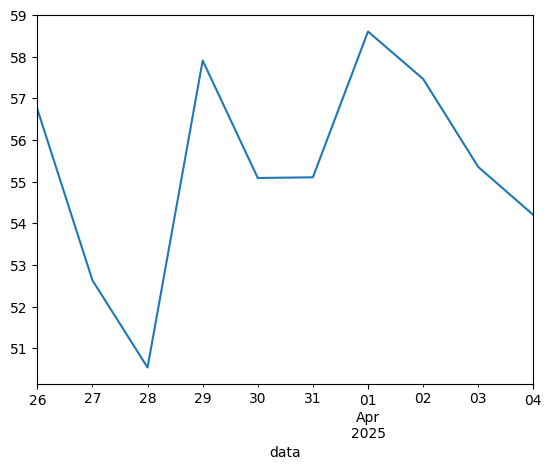

In [21]:
df_forecast.groupby('data')['previsao_vendas'].sum().plot(kind='line')